In [1]:
from dotenv import load_dotenv
from pycaret.regression import setup, compare_models, finalize_model, save_model
import boto3
import os
import pandas as pd
import seaborn as sns
from datetime import datetime


load_dotenv()
s3 = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    endpoint_url=os.getenv("AWS_ENDPOINT_URL_S3"), 

)
BUCKET_NAME = "cersei568"



df=pd.read_csv(f"s3://{BUCKET_NAME}/upload/halfmarathon_wroclaw_2024__final.csv", sep=";")

df.sample(5)

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
3734,3735.0,6600,MARIOLA,MATKOWSKA,LEWIN BRZESKI,POL,NaN,K,467.0,K40,...,5.296667,01:21:53,4115.0,5.650000,01:49:40,3789.0,5.556667,0.014667,01:55:56,5.495773
4121,4122.0,11979,ANTONI,DOMAGAŁA,BIELAWA,POL,BRAK,M,3558.0,M20,...,5.273333,01:20:44,3716.0,5.660000,01:50:50,4087.0,6.020000,0.056133,01:57:35,5.573991
3226,3227.0,3511,JAKUB,SZUMNY,TYCHY,POL,-,M,2866.0,M30,...,5.346667,01:20:29,3614.0,5.563333,01:47:30,3271.0,5.403333,0.017333,01:53:40,5.388323
203,204.0,391,TADEUSZ,KĘDZIOR,TONSBERG,POL,NaN,M,198.0,M40,...,3.930000,01:01:16,185.0,4.316667,01:23:28,205.0,4.440000,0.033733,01:28:19,4.186616
12021,NaN,29756,ARTUR,PIRA,NaN,NaN,NaN,M,NaN,M20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
df.isna().sum()

Miejsce                      2707
Numer startowy                  0
Imię                            0
Nazwisko                        0
Miasto                       3094
Kraj                         2707
Drużyna                      8026
Płeć                            9
Płeć Miejsce                 2707
Kategoria wiekowa              20
Kategoria wiekowa Miejsce    2718
Rocznik                       284
5 km Czas                    2719
5 km Miejsce Open            2719
5 km Tempo                   2719
10 km Czas                   2719
10 km Miejsce Open           2719
10 km Tempo                  2728
15 km Czas                   2720
15 km Miejsce Open           2720
15 km Tempo                  2730
20 km Czas                   2712
20 km Miejsce Open           2712
20 km Tempo                  2722
Tempo Stabilność             2740
Czas                         2055
Tempo                        2707
dtype: int64

In [3]:
def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

In [4]:
df['Czas'] = df['Czas'].apply(convert_time_to_seconds)

df['5 km Czas'] = df['5 km Czas'].apply(convert_time_to_seconds)
df['Czas'].head()

0    3843.0
1    3864.0
2    3880.0
3    4184.0
4    4205.0
Name: Czas, dtype: float64

In [5]:
df = df.dropna(subset=['Rocznik', 'Płeć', '5 km Czas', "Czas"])

CURRENT_YEAR = datetime.now().year

df['Wiek'] = CURRENT_YEAR - df["Rocznik"].astype(int)
df['Płeć'] = df["Płeć"].map({"M": 0, "K": 1})


In [6]:
# teraz sprawdź rozmiar
print(df.shape)
print(df['Wiek'].isna().sum())

(10004, 28)
0


In [7]:
features = ['Wiek', 'Płeć', '5 km Czas']
df = df[features + ['Czas']]

In [8]:
Q1 = df["Czas"].quantile(0.25)
Q3 = df["Czas"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[~((df["Czas"] < lower_bound) | (df["Czas"] > upper_bound))]

In [9]:
Q1 = df["Wiek"].quantile(0.25)
Q3 = df["Wiek"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[~((df["Wiek"] < lower_bound) | (df["Wiek"] > upper_bound))]

<Axes: xlabel='Wiek', ylabel='Czas'>

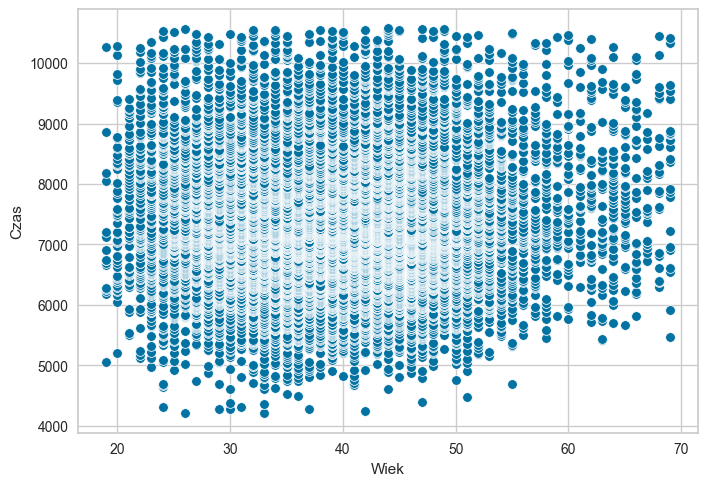

In [10]:
sns.scatterplot(data=df, x="Wiek", y="Czas")

In [11]:
from pycaret.regression import setup, compare_models, finalize_model, save_model

training_df = df[['Wiek', 'Płeć', '5 km Czas', 'Czas']]

setup(
    data=training_df,
    target='Czas',
    session_id=123,
    verbose=False,
)

best_model = compare_models()
best_final_model = finalize_model(best_model)

save_model(best_final_model, "best_finalized_model")

s3.upload_file(
    Filename="best_finalized_model.pkl",
    Bucket=BUCKET_NAME,
    Key="models/best_finalized_model.pkl"
)





,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,291.9431,157024.7035,395.9615,0.8813,0.0509,0.0384,0.0560
lr,Linear Regression,292.7124,162236.5328,401.6078,0.8773,0.0586,0.0385,0.5220
lasso,Lasso Regression,292.7220,162241.9453,401.6166,0.8773,0.0586,0.0385,0.0070
ridge,Ridge Regression,292.7124,162236.4469,401.6077,0.8773,0.0586,0.0385,0.0050
en,Elastic Net,292.7568,162256.7031,401.6412,0.8773,0.0588,0.0385,0.0050
lar,Least Angle Regression,292.7124,162236.4984,401.6077,0.8773,0.0586,0.0385,0.0040
llar,Lasso Least Angle Regression,292.7220,162241.9453,401.6166,0.8773,0.0586,0.0385,0.0040
br,Bayesian Ridge,292.7840,162273.7281,401.6638,0.8773,0.0589,0.0385,0.0100
omp,Orthogonal Matching Pursuit,292.9748,162403.9875,401.8197,0.8772,0.0590,0.0385,0.0040
lightgbm,Light Gradient Boosting Machine,297.4859,162743.4922,403.1258,0.8770,0.0517,0.0391,0.2500


Transformation Pipeline and Model Successfully Saved


In [12]:
df[['Czas']].to_csv("reference_times.csv", index=False)
s3.upload_file("reference_times.csv", BUCKET_NAME, "models/reference_times.csv")
